In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import os

sys.path.append('../..')

import torch

In [2]:
with open(r"/home/mikemaslyaev/Documents/HighValue/res_8_9_at_17_5.pickle", 'rb') as input_file:  
    res = pickle.load(input_file)

/home/mikemaslyaev/.local/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [70]:
res[1]

Sequential(
  (0): Linear(in_features=2, out_features=25, bias=True)
  (1): Tanh()
  (2): Linear(in_features=25, out_features=1, bias=True)
)

In [12]:
res[3]

[tensor(25.5001, device='cuda:0'),
 tensor(25.6988, device='cuda:0'),
 tensor(25.6989, device='cuda:0'),
 tensor(25.5963, device='cuda:0'),
 tensor(25.4213, device='cuda:0'),
 tensor(25.3044, device='cuda:0'),
 tensor(25.1422, device='cuda:0'),
 tensor(25.0009, device='cuda:0'),
 tensor(24.7302, device='cuda:0'),
 tensor(24.5394, device='cuda:0'),
 tensor(24.4114, device='cuda:0'),
 tensor(24.4150, device='cuda:0'),
 tensor(24.3478, device='cuda:0'),
 tensor(24.2987, device='cuda:0'),
 tensor(24.2412, device='cuda:0'),
 tensor(24.2798, device='cuda:0'),
 tensor(24.1498, device='cuda:0'),
 tensor(24.2595, device='cuda:0'),
 tensor(24.1899, device='cuda:0'),
 tensor(24.1520, device='cuda:0'),
 tensor(24.1245, device='cuda:0'),
 tensor(24.0438, device='cuda:0'),
 tensor(23.9450, device='cuda:0'),
 tensor(23.8391, device='cuda:0'),
 tensor(23.7518, device='cuda:0'),
 tensor(23.6553, device='cuda:0'),
 tensor(23.5351, device='cuda:0'),
 tensor(23.4510, device='cuda:0'),
 tensor(23.3639, dev

In [6]:
t = np.linspace(0, 0.5, res[2].size()[0])

torch.Size([100, 1])

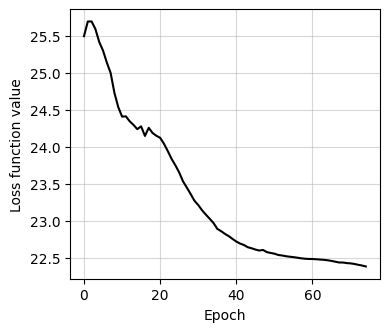

In [67]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42   
plt.rcParams["figure.figsize"] = (4.0, 3.5)

fig, ax1 = plt.subplots()
ax1.grid(alpha = 0.5)

ax1.plot([res[3][i].detach().cpu().numpy() for i in range(len(res[3]))], color = 'k', label = 'Loss function value')
# ax1.legend()

ax1.set_xlabel('Epoch')
# mn, mx = ax1.set_ylim(-1, 5)
ax1.set_ylabel('Loss function value')

plt.savefig('/home/mikemaslyaev/Documents/HighValue/LV_loss_func.png', dpi = 400, bbox_inches='tight')

In [16]:
u_plots, v_plots = torch.linspace(0, 4, 61), torch.linspace(0, 4, 61)
UU, VV = torch.meshgrid(u_plots, v_plots)
ctrl_args = torch.stack(tensors = (UU.reshape(-1), VV.reshape(-1)), dim = 0).T.cuda()

ctrl_landscape = res[1](ctrl_args).cpu().detach().numpy().reshape((u_plots.size()[0], v_plots.size()[0]))

In [29]:
t = torch.linspace(0., 0.5, 100).reshape((-1, 1)).cuda()
sol = res[0](t).detach().cpu().numpy()
sol.shape

(100, 2)

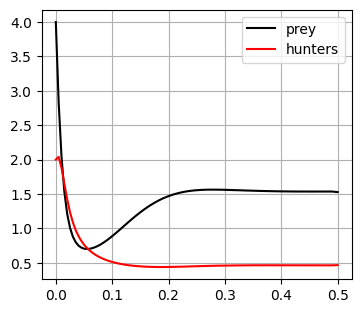

In [30]:
# import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42    

plt.rcParams["figure.figsize"] = (4.0, 3.5)
# my_dict = {'Single Objective': obj_funs_so, 'Multi-Objective': obj_funs_mo}

plt.plot(t.cpu().numpy(), sol[:, 0], color ='k', label = 'prey')
plt.plot(t.cpu().numpy(), sol[:, 1], color ='r', label = 'hunters')
plt.grid()
plt.legend()
plt.show()

In [50]:
from typing import Callable, Union

def controlled_lv_by_RK_t(initial : tuple, timestep : float, steps : int, alpha : float, 
                          beta : float, delta : float, gamma : float, c1: float = 0, c2: float = 0,
                          conrol_intensity: Union[np.ndarray, Callable] = lambda x: 1):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    if not isinstance(conrol_intensity, np.ndarray):
        conrol_intensity_vect = np.vectorize(conrol_intensity)
        conrol_intensity = conrol_intensity_vect(np.linspace(0, steps*timestep, steps*2 - 1))
    assert conrol_intensity.size == steps*2-1, 'Incorrect shape of control, not taking Runge-Kutta half-steps into account'

    for step in range(steps-1):
        alpha_1 = alpha - c1*conrol_intensity[2*step]
        alpha_2 = alpha - c1*conrol_intensity[2*step + 1]
        alpha_3 = alpha - c1*conrol_intensity[2*step + 2]

        gamma_1 = gamma + c2*conrol_intensity[2*step]
        gamma_2 = gamma + c2*conrol_intensity[2*step + 1]
        gamma_3 = gamma + c2*conrol_intensity[2*step + 2]


        k1 = alpha_1 * res[step, 0] - beta * res[step, 0] * res[step, 1]; x1 = res[step, 0] + timestep/2. * k1
        l1 = delta * res[step, 0] * res[step, 1] - gamma_1 * res[step, 1]; y1 = res[step, 1] + timestep/2. * l1

        k2 = alpha_2 * x1 - beta * x1 * y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = delta * x1 * y1 - gamma_2 * y1; y2 = res[step, 1] + timestep/2. * l2

        k3 = alpha_2 * x2 - beta * x2 * y2
        l3 = delta * x2 * y2 - gamma_2 * y1
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3
        k4 = alpha_3 * x3 - beta * x3 * y3
        l4 = delta * x3 * y3 - gamma_3 * y3
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return res

def controlled_lv_by_RK(initial : tuple, timestep : float, steps : int, alpha : float, 
                        beta : float, delta : float, gamma : float, c1: float = 0, c2: float = 0,
                        control_intensity: Union[Callable, torch.nn.Sequential] = lambda x: 1):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    controls = np.zeros(shape = steps)

    if isinstance(control_intensity, torch.nn.Sequential):
        prepare_input = lambda *args: torch.from_numpy(np.array(args))
    else:
        prepare_input = lambda *args: args

    for step in range(steps-1):
        ctrl_val_1 = control_intensity(prepare_input(res[step, 0], res[step, 1]))
        controls[step] = ctrl_val_1

        alpha_1 = alpha - c1 * ctrl_val_1
        gamma_1 = gamma + c2 * ctrl_val_1

        k1 = alpha_1 * res[step, 0] - beta * res[step, 0] * res[step, 1]; x1 = res[step, 0] + timestep/2. * k1
        l1 = delta * res[step, 0] * res[step, 1] - gamma_1 * res[step, 1]; y1 = res[step, 1] + timestep/2. * l1

        ctrl_val_2 = control_intensity(prepare_input(x1, y1))
        alpha_2 = alpha - c1 * ctrl_val_2
        gamma_2 = gamma + c2 * ctrl_val_2

        k2 = alpha_2 * x1 - beta * x1 * y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = delta * x1 * y1 - gamma_2 * y1; y2 = res[step, 1] + timestep/2. * l2

        ctrl_val_3 = control_intensity(prepare_input(x2, y2))
        alpha_3 = alpha - c1 * ctrl_val_3
        gamma_3 = gamma + c2 * ctrl_val_3

        k3 = alpha_3 * x2 - beta * x2 * y2
        l3 = delta * x2 * y2 - gamma_3 * y1
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3

        alpha_4 = alpha - c1*control_intensity(prepare_input(x3, y3))
        gamma_4 = gamma + c2*control_intensity(prepare_input(x3, y3))

        k4 = alpha_4 * x3 - beta * x3 * y3
        l4 = delta * x3 * y3 - gamma_4 * y3
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return controls, res

def prepare_data(steps_num: int = 151, t_max: float = 0.5, ctrl_fun: Callable = lambda x: x[0]*x[1]):
    # def get_sine_control(ampl: float = 1, period: float = 1., 
    #                      phase_shift: float = 0.) -> Callable:
    #     return lambda x: ampl*(np.sin(2*np.pi/period*(x + phase_shift)) + 1.)
    
    step = t_max/steps_num
    t = np.arange(start = 0, stop = step * steps_num, step = step)
    # ctrl = get_sine_control(ampl = 15., period=0.3)(np.linspace(0, 1, t.size*2 - 1))
    ctrl, solution = controlled_lv_by_RK(initial=(4., 2.), timestep=step, steps=steps_num, 
                                   alpha=20., beta=20., delta=20., gamma=20., 
                                   c1 = 1., c2 = 1., control_intensity = ctrl_fun)

    return t, ctrl, solution

In [53]:
t_sample, ctrl_sample, solution_sample = prepare_data(steps_num = 100, ctrl_fun = lambda x: 12*x[1] + 0.05*x[0] + 0.2) # x[0]

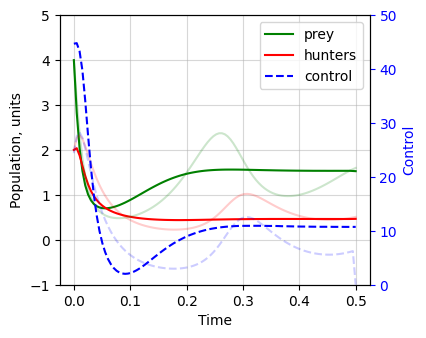

In [68]:
# mean, amp = 40000, 20000
# t = np.arange(50)
# s1 = np.sin(t)*amp + mean #synthetic ts, but closer to my data 

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42   
plt.rcParams["figure.figsize"] = (4.0, 3.5)

fig, ax1 = plt.subplots()
ax1.grid(alpha = 0.5)
ln_prey = ax1.plot(t.cpu().numpy(), sol[:, 0], color ='g', label = 'prey')
ln_hunt = ax1.plot(t.cpu().numpy(), sol[:, 1], color ='r', label = 'hunters')
ln_prey_smp = ax1.plot(t.cpu().numpy(), solution_sample[:, 0], color = 'g', alpha = 0.2, label = 'Prey, relative units')
ln_hunt_smp = ax1.plot(t.cpu().numpy(), solution_sample[:, 1], color = 'r', alpha = 0.2, label = 'Hunters, relative units')
ax1.set_xlabel('Time')
mn, mx = ax1.set_ylim(-1, 5)
ax1.set_ylabel('Population, units')

# km3yearToSv = 31.6887646e-6

ax2 = ax1.twinx()
ln_ctrl = ax2.plot(t.cpu().numpy(), res[2].detach().cpu().numpy(), '--', color ='b', label = 'control')
ax2.plot(t.cpu().numpy(), ctrl_sample, '--', color ='b',  alpha = 0.2, label = 'control')
lns = ln_prey + ln_hunt + ln_ctrl
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax2.set_ylim(0, 50)
ax2.set_ylabel('Control')
ax2.tick_params(axis='y', colors='blue')
ax2.yaxis.label.set_color('blue')
ax2.title.set_color('blue')

plt.savefig('/home/mikemaslyaev/Documents/HighValue/LV_ctrl_dyn.png', dpi = 400, bbox_inches='tight')

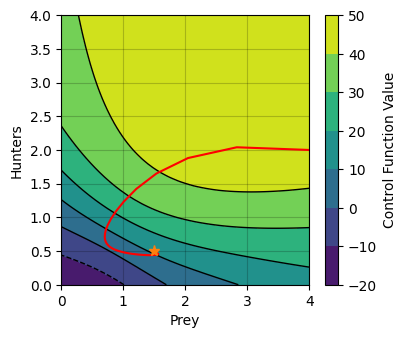

In [45]:
fig, axs = plt.subplots()
cs = axs.contourf(UU.detach().numpy(), VV.detach().numpy(), ctrl_landscape)
axs.contour(cs, colors='k', linewidths=1.0)
axs.grid(c='k', ls='-', alpha=0.2)
axs.plot(sol[:, 0], sol[:, 1], color = 'r')
axs.plot([1.5,], [0.5,], '*', color = 'tab:orange', markersize=8)
axs.set_xlabel('Prey')
axs.set_ylabel('Hunters')

cbar = fig.colorbar(cs, ax=axs)

cbar.ax.set_ylabel('Control Function Value', rotation=90)
plt.savefig('/home/mikemaslyaev/Documents/HighValue/control_landscape.png', dpi = 300, bbox_inches='tight')
# axs[0].plot(np.ma.array(x, mask=~mask), y, 'ro')